## 1. Dependencies Import

In [415]:
# Essential libraries for data handling and modeling
import math
import pandas as pd
import numpy as np

# Machine learning libraries
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap

# Hyperparameters tuning library
import optuna
from optuna.samplers import TPESampler

# Other libraries
from datetime import datetime
import pickle

# Project-specific modules
from config.utils import load_config
from utils.data_preprocessing import (
    add_fighter_odds,
    add_fighter_prefix,
    get_seconds,
    get_lan_thr_cols,
    get_fight_lasted,
    get_weight_class,
    feet_to_inches,
    swap_fighter_positions,
    remove_inch_sign
)
from utils.feature_selection_and_creation import (
    get_rolling_features,
    get_stats
)
from utils.visualization import (
    plot_corr_matrix,
    plot_countplot,
    plot_lineplot,
    plot_hist,
    plot_scatterplots
)


shap.initjs()

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

CONFIG_PATH = './config/config.yaml'
config = load_config(CONFIG_PATH)

EVENTS_COLUMNS = config.get("EVENTS_COLUMNS")
COLUMNS_TO_SPLIT = config.get("COLUMNS_TO_SPLIT")
COLUMNS_TO_RENAME = config.get("COLUMNS_TO_RENAME")
COLUMNS_TO_REMOVE = config.get("COLUMNS_TO_REMOVE")
COLUMNS_TO_SHIFT = config.get("COLUMNS_TO_SHIFT")
COLUMNS_TO_SWAP = config.get("COLUMNS_TO_SWAP")
COLUMNS_TO_GET_ROLLING_MEANS = config.get("COLUMNS_TO_GET_ROLLING_MEANS")
COLUMNS_FOR_SUBPLOTS = config.get("COLUMNS_FOR_SUBPLOTS")

## 2. Data Collection

<div style="margin-left: 2em;">
<font color='gray'>Web scrapers were written and then data was pulled. All the files are available in "web_scrapers" folder.</font>
</div>


## 3. Data Cleaning

### <div style="margin-left: 1em;">Fighter's Features Description</div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fighter's carrier statistics taken as of February 2024. Most of them are pretty self explanatory except maybe for the "record" and "dob" which are date of birth and number of wins, losses, draws and no-contests (if value is present) respectively.</font></div>

In [416]:
fighters_df = pd.read_csv(
    './web_scrapers/fighters_stats.csv', header=0, sep=','
)
fighters_df.head()

,name,record,height,weight,reach,stance,dob
0,Tom Aaron,5-3-0,--,155 lbs.,--,NaN,"Jul 13, 1978"
1,Danny Abbadi,4-6-0,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983"
2,Nariman Abbasov,28-4-0,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994"
3,David Abbott,10-15-0,"6' 0""",265 lbs.,--,Switch,--
4,Hamdy Abdelwahab,5-0-0 (1 NC),"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993"


In [417]:
fighters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4113 non-null   object
 1   record  4113 non-null   object
 2   height  4113 non-null   object
 3   weight  4113 non-null   object
 4   reach   4113 non-null   object
 5   stance  3288 non-null   object
 6   dob     4113 non-null   object
dtypes: object(7)
memory usage: 225.1+ KB


In [418]:
fighters_df.describe(include='object')

,name,record,height,weight,reach,stance,dob
count,4113,4113,4113,4113,4113,3288,4113
unique,4107,1222,27,113,28,5,2845
top,Mike Davis,0-1-0,"6' 0""",155 lbs.,--,Orthodox,--
freq,2,78,437,621,1929,2526,755


In [419]:
fighters_df.loc[fighters_df.duplicated('name', keep=False)]

,name,record,height,weight,reach,stance,dob
821,Mike Davis,2-0-0,--,--,--,NaN,--
826,Mike Davis,10-2-0,"6' 0""",155 lbs.,"72""",Orthodox,"Oct 07, 1992"
1308,Joey Gomez,6-2-0,"5' 10""",135 lbs.,"73""",Orthodox,"Jul 21, 1986"
1310,Joey Gomez,7-1-0,"5' 10""",155 lbs.,"71""",Orthodox,"Aug 29, 1989"
1742,Tony Johnson,7-2-0,"6' 2""",205 lbs.,"76""",Orthodox,"May 02, 1983"
1750,Tony Johnson,11-3-0,"6' 1""",265 lbs.,--,NaN,--
2328,Michael McDonald,1-1-0,"5' 11""",205 lbs.,--,Orthodox,"Feb 06, 1965"
2330,Michael McDonald,17-4-0,"5' 9""",135 lbs.,"70""",Orthodox,"Jan 15, 1991"
3412,Jean Silva,19-12-3 (1 NC),"5' 6""",160 lbs.,--,Orthodox,"Oct 08, 1977"
3426,Bruno Silva,13-5-2 (1 NC),"5' 4""",125 lbs.,"65""",Orthodox,"Mar 16, 1990"


In [420]:
# Dropping fighters with the same name as we won't be able to 
# figure out for instance which Mike Davis fought in a fight 
fighters_df = (
    fighters_df[~fighters_df.duplicated('name', keep=False)]
        .reset_index(drop=True)
)

# Replacing "--" with NaNs
fighters_df.replace('--', np.nan, inplace=True)

# Converting "dob" column to datetime type
fighters_df.dob = fighters_df.dob.apply(
    lambda x: datetime.strptime(x, '%b %d, %Y') if pd.notnull(x) else x
)

# Converting "height" to inches
fighters_df['height'] = fighters_df['height'].apply(feet_to_inches)

# Removing the '"' sign 
fighters_df['reach'] = fighters_df['reach'].apply(remove_inch_sign)


# Dropping 'weight' column as it's the last observed weight of the fighter
# and it is not relevant for the model as it a constant feature 
# Dropping 'record' column as it's a rolling feature taken only as of Feb, 2024
# Later on we'll create rolling features for each fighter's event 
fighters_df.drop(['record', 'weight'], axis=1, inplace=True)

fighters_df.head()

,name,height,reach,stance,dob
0,Tom Aaron,NaN,NaN,NaN,1978-07-13
1,Danny Abbadi,71.0,NaN,Orthodox,1983-07-03
2,Nariman Abbasov,68.0,66,Orthodox,1994-02-01
3,David Abbott,72.0,NaN,Switch,NaT
4,Hamdy Abdelwahab,74.0,72,Southpaw,1993-01-22


### <div style="margin-left: 1em;">Fight's Additional Features Description </div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fights's statistics along with the betting odds taken as of February 2024.</font></div>

In [421]:
fights_odds_df = pd.read_csv(
    './web_scrapers/fights_odds.csv', header=0, sep=','
)
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jim Miller,1.40,Pat Healy,3.40,Underdog


In [422]:
fights_odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event           4227 non-null   object 
 1   date            4227 non-null   object 
 2   favourite       4227 non-null   object 
 3   favourite_odds  4227 non-null   float64
 4   underdog        4227 non-null   object 
 5   underdog_odds   4227 non-null   float64
 6   result          4227 non-null   object 
dtypes: float64(2), object(5)
memory usage: 231.3+ KB


In [423]:
fights_odds_df.describe(include='object')

,event,date,favourite,underdog,result
count,4227,4227,4227,4227,4227
unique,346,355,1242,1402,3
top,UFC FN,19th Nov 2016,Vicente Luque,Andrei Arlovski,Favourite
freq,136,25,15,21,2712


In [424]:
fights_odds_df.describe()

,favourite_odds,underdog_odds
count,4227.00,4227.00
mean,inf,inf
std,NaN,NaN
min,1.06,1.88
25%,1.38,2.35
50%,1.56,2.80
75%,1.73,3.63
max,inf,inf


In [425]:
# Converting "date" column to datetime type
fights_odds_df.date = pd.to_datetime(
    fights_odds_df.date.replace({'(st|nd|rd|th)': ''}, regex=True), 
    format="%d %b %Y"
)

# Replacing "inf" with NaNs
fights_odds_df.underdog_odds = (
    fights_odds_df.underdog_odds.replace(np.inf, np.nan)
)
fights_odds_df.favourite_odds = (
    fights_odds_df.favourite_odds.replace(np.inf, np.nan)
)

fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,2013-04-27,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,2013-04-27,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,2013-04-27,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,2013-04-27,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,2013-04-27,Jim Miller,1.40,Pat Healy,3.40,Underdog


### <div style="margin-left: 1em;">Fight's Base Features Description</div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fight's statistics taken as of February 2024.
Prefixes <font color='#A9A9A9'><strong>f1_</strong></font> and <font color='#A9A9A9'><strong>f2_</strong></font> stand for the first and second fighters statistics respectively.

Some features described:
- **<font color='#A9A9A9'>fighter_1_result</font>**: The result of the fight for Fighter 1 (win, lose, draw or nc).
- **<font color='#A9A9A9'>title</font>**: Indicates the title type (e.g., championship, interim).
- **<font color='#A9A9A9'>method</font>**: The method by which the fight was won (e.g., KO, submission, decision).
- **<font color='#A9A9A9'>last_round</font>**: The round in which the fight ended (if applicable).
- **<font color='#A9A9A9'>last_round_time</font>**: The time at which the fight ended in the last round (if applicable).
- **<font color='#A9A9A9'>time_format</font>**: The format used to denote time (e.g., minutes and seconds).
- **<font color='#A9A9A9'>referee</font>**: The referee who officiated the fight.
- **<font color='#A9A9A9'>details</font>**: Additional details about the fight outcome or circumstances.
- **<font color='#A9A9A9'>total_knock_downs</font>**: The total number of knockdowns scored by a fighter.
- **<font color='#A9A9A9'>total_signif_str</font>**: The total significant strikes landed by a fighter.
- **<font color='#A9A9A9'>total_total_str</font>**: The total strikes (significant and non-significant) landed by a fighter.
- **<font color='#A9A9A9'>total_take_downs</font>**: The total takedowns executed by a fighter.
- **<font color='#A9A9A9'>total_sub_atts</font>**: The total submission attempts made by a fighter.
- **<font color='#A9A9A9'>total_rev</font>**: The total reversals executed by a fighter.
- **<font color='#A9A9A9'>total_ctrl</font>**: The total control time (time spent in dominant positions) for a fighter.
- **<font color='#A9A9A9'>total_head</font>**: The total strikes landed to the head by a fighter.
- **<font color='#A9A9A9'>total_body</font>**: The total strikes landed to the body by a fighter.
- **<font color='#A9A9A9'>total_leg</font>**: The total strikes landed to the legs by a fighter.
- **<font color='#A9A9A9'>total_distance</font>**: The total strikes landed from a distance by a fighter.
- **<font color='#A9A9A9'>total_clinch</font>**: The total strikes landed in the clinch by a fighter.
- **<font color='#A9A9A9'>total_ground</font>**: The total strikes landed on the ground by a fighter.</font></div>

In [426]:
fights_df = pd.read_csv(
    './web_scrapers/fights_stats.csv', header=0
)
column_rename = {
    "fighter_1": "f1_name",
    "fighter_2": "f2_name"
}

fights_df = fights_df.rename(columns=column_rename)
fights_df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA","Dec. 04, 2010",Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA","May. 15, 2010",Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA","Sep. 23, 2006",Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA","Jun. 24, 2006",Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0
4,DWCS 6.7,"Las Vegas, Nevada, USA","Sep. 06, 2022",Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0


In [427]:
fights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19838 entries, 0 to 19837
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_name            19838 non-null  object 
 1   event_location        19838 non-null  object 
 2   event_datetime        19838 non-null  object 
 3   f1_name               19838 non-null  object 
 4   f2_name               19838 non-null  object 
 5   fighter_1_result      19838 non-null  object 
 6   title                 19838 non-null  object 
 7   method                19838 non-null  object 
 8   last_round            19838 non-null  int64  
 9   last_round_time       19838 non-null  object 
 10  time_format           19838 non-null  object 
 11  referee               19246 non-null  object 
 12  details               19044 non-null  object 
 13  f1_total_knock_downs  19178 non-null  float64
 14  f2_total_knock_downs  19178 non-null  float64
 15  f1_total_signif_str

In [428]:
fights_df.describe(include='object')

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round_time,time_format,referee,details,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
count,19838,19838,19838,19838,19838,19838,19838,19838,19838,19838,19246,19044,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178
unique,1122,214,1079,2422,3310,4,158,11,438,36,276,4117,4582,4393,5856,5422,183,182,790,663,3863,3634,727,684,502,498,3640,3656,615,569,895,615
top,UFC 2: No Way Out,"Las Vegas, Nevada, USA","Nov. 19, 2016",Mauricio Rua,Jeremy Stephens,W,Lightweight Bout,Decision - Unanimous,5:00,3 Rnd (5-5-5),Herb Dean,Punch to Head At Distance,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,--,--,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0
freq,30,6038,50,74,42,13678,3198,6528,8520,16050,2562,1556,120,246,82,158,6194,7342,3170,3170,224,450,2366,2944,4150,4298,406,426,4792,4988,6142,8802


In [429]:
fights_df.describe()

,last_round,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev
count,19838.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000
mean,2.230971,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958
std,1.018746,0.530361,0.431678,0.969577,0.778358,0.437575,0.444267
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,6.000000,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000


In [430]:
fights_df.duplicated().sum()

9919

In [431]:
# Dropping duplicates
fights_df = fights_df[~fights_df.duplicated()] \
    .reset_index() \
    .drop('index', axis=1)

# Replacing "--" with NaNs
fights_df.replace('--', np.nan, inplace=True)

# Converting "event_datetime" column to datetime type
fights_df.event_datetime = fights_df.event_datetime.apply(
    lambda x: datetime.strptime(x, '%b. %d, %Y')
)

# Adding odds to the main dataframe

fights_df = add_fighter_odds(fights_df, fights_odds_df)
del fights_odds_df
fights_df.sample(5)

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds
5267,UFC 60: Hughes vs Gracie,"Los Angeles, California, USA",2006-05-27,Gabriel Gonzaga,Fabiano Scherner,W,Heavyweight Bout,KO/TKO,2,0:24,3 Rnd (5-5-5),Steve Mazzagatti,Punch to Head At Distance,1.0,0.0,16 of 30,8 of 25,34 of 50,24 of 41,3 of 4,0 of 1,0.0,0.0,0.0,1.0,2:23,0:38,11 of 25,6 of 20,3 of 3,2 of 5,2 of 2,0 of 0,8 of 19,5 of 14,4 of 4,3 of 10,4 of 7,0 of 1,NaN,NaN
510,UFC 249: Ferguson vs. Gaethje,"Jacksonville, Florida, USA",2020-05-09,Ryan Spann,Sam Alvey,W,Light Heavyweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,Sal D'amato28 - 29.Dave Tirelli28 - 29.Chris L...,0.0,0.0,51 of 115,57 of 108,52 of 116,103 of 156,2 of 7,0 of 0,1.0,0.0,0.0,0.0,3:01,0:29,41 of 102,40 of 90,10 of 13,3 of 3,0 of 0,14 of 15,48 of 109,46 of 94,3 of 6,11 of 14,0 of 0,0 of 0,NaN,NaN
4328,UFC on FOX: VanZant vs. Waterson,"Sacramento, California, USA",2016-12-17,Josh Emmett,Scott Holtzman,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Mike Guingona28 - 29.Wade Vierra28 - 29.Brando...,0.0,0.0,87 of 160,65 of 179,99 of 175,96 of 215,8 of 12,3 of 4,1.0,0.0,0.0,0.0,3:59,3:15,50 of 119,48 of 148,26 of 30,16 of 30,11 of 11,1 of 1,47 of 109,38 of 132,35 of 44,24 of 42,5 of 7,3 of 5,1.61,2.55
8778,UFC Fight Night: Costa vs. Vettori,"Las Vegas, Nevada, USA",2021-10-23,Tabatha Ricci,Maria Oliveira,W,Women's Strawweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Keith Peterson,Junichiro Kamijo27 - 30.Tony Weeks27 - 30.Doug...,0.0,0.0,62 of 135,66 of 178,103 of 187,90 of 207,5 of 11,0 of 0,0.0,0.0,0.0,0.0,6:38,0:01,42 of 109,34 of 128,12 of 16,18 of 33,8 of 10,14 of 17,29 of 98,61 of 172,5 of 5,4 of 4,28 of 32,1 of 2,1.42,3.30
7802,UFC 204: Bisping vs. Henderson,"Manchester, England, United Kingdom",2016-10-08,Ovince Saint Preux,Jimi Manuwa,L,Light Heavyweight Bout,KO/TKO,2,2:38,3 Rnd (5-5-5),Leon Roberts,Punch to Head In Clinch,0.0,1.0,13 of 38,32 of 47,17 of 44,33 of 48,2 of 3,0 of 3,0.0,1.0,0.0,0.0,3:26,0:30,7 of 29,12 of 25,4 of 7,9 of 11,2 of 2,11 of 11,10 of 34,20 of 32,2 of 3,12 of 14,1 of 1,0 of 1,1.67,2.45


In [432]:
# Merging dataframes to retrieve fighter's individual static information 
# such as height, reach, etc
fights_df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f1_'), 
    how='left', 
    on='f1_name'
)
df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f2_'), 
    how='left', 
    on='f2_name'
)

del fights_df
df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA",2010-12-04,Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA",2010-05-15,Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA",2006-09-23,Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA",2006-06-24,Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03
4,DWCS 6.7,"Las Vegas, Nevada, USA",2022-09-06,Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71,Orthodox,1995-12-28,68.0,66,Orthodox,1994-02-01


In [433]:
# Extracting event country
df['event_country'] = (
    df.event_location.str.split(',').str.get(-1).fillna(df.event_location)
)
df = df.drop('event_location', axis=1)

# Transforming event target
df.rename(
    columns={'fighter_1_result':'target', 'event_datetime':'event_date'},
    inplace=True
)

# Creating column indicating if the fight is for the interim's belt
df['is_interim_fight'] = df.apply(
    lambda entry: 1 if 'interim' in entry.title.lower() else 0,
    axis = 1
)

# Creating column indicating if the fight is for the champion's belt
df['is_title_fight'] = df.apply(
    lambda entry: 
        1 if ('title' in entry.title.lower()) &
        (entry.is_interim_fight != 1)
        else 0,
    axis = 1
)

# Creating column indicating if the fight is in women league
df['is_women_fight'] = df.apply(
    lambda entry: 1 if 'women' in entry.title.lower() else 0,
    axis = 1
)
  
# Getting weight class
df['weight_class'] = df['title'].apply(
    lambda title: get_weight_class(title)
)

# Dropping 'title' and 'event_name' columns
df = df.drop(["title","event_name"], axis=1)

# Mapping target
df.target = df.target.map({'W':'F1', 'L':'F2', 'D':'Draw', 'NC':'NC'})

df.head()

,event_date,f1_name,f2_name,target,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class
0,2010-12-04,Tom Aaron,Matt Ricehouse,F2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11,USA,0,0,0,lightweight
1,2010-05-15,Tom Aaron,Eric Steenberg,F1,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22,USA,0,0,0,catch weight
2,2006-09-23,Jorge Gurgel,Danny Abbadi,F1,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03,USA,0,0,0,lightweight
3,2006-06-24,Kalib Starnes,Danny Abbadi,F1,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03,USA,0,0,0,middleweight
4,2022-09-06,Ismael Bonfim,Nariman Abbasov,F1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71,Orthodox,1995-12-28,68.0,66,Orthodox,1994-02-01,USA,0,0,0,lightweight


In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   event_date            9919 non-null   datetime64[ns]
 1   f1_name               9919 non-null   object        
 2   f2_name               9919 non-null   object        
 3   target                9919 non-null   object        
 4   method                9919 non-null   object        
 5   last_round            9919 non-null   int64         
 6   last_round_time       9919 non-null   object        
 7   time_format           9919 non-null   object        
 8   referee               9623 non-null   object        
 9   details               9522 non-null   object        
 10  f1_total_knock_downs  9589 non-null   float64       
 11  f2_total_knock_downs  9589 non-null   float64       
 12  f1_total_signif_str   9589 non-null   object        
 13  f2_total_signif_st

In [435]:
sorted(df.time_format.unique().tolist())

['1 Rnd (10)',
 '1 Rnd (12)',
 '1 Rnd (15)',
 '1 Rnd (18)',
 '1 Rnd (20)',
 '1 Rnd (30)',
 '1 Rnd + 2OT (15-3-3)',
 '1 Rnd + 2OT (24-3-3)',
 '1 Rnd + OT (12-3)',
 '1 Rnd + OT (15-10)',
 '1 Rnd + OT (15-3)',
 '1 Rnd + OT (27-3)',
 '1 Rnd + OT (30-3)',
 '1 Rnd + OT (30-5)',
 '1 Rnd + OT (31-5)',
 '2 Rnd (10-10)',
 '2 Rnd (10-5)',
 '2 Rnd (3-3)',
 '2 Rnd (5-5)',
 '3 Rnd (10-10-10)',
 '3 Rnd (10-10-5)',
 '3 Rnd (10-5-5)',
 '3 Rnd (2-2-2)',
 '3 Rnd (3-3-3)',
 '3 Rnd (4-4-4)',
 '3 Rnd (5-5-5)',
 '3 Rnd (8-8-8)',
 '3 Rnd + OT (5-5-5-5)',
 '4 Rnd (10-10-10-10)',
 '5 Rnd (3-3-3-3-3)',
 '5 Rnd (4-4-4-4-4)',
 '5 Rnd (5-5-5-5-5)',
 'No Time Limit',
 'Unlimited Rnd  (15)',
 'Unlimited Rnd (10)',
 'Unlimited Rnd (20)']

In [436]:
# Getting how many seconds the fight lasted
df['fight_lasted'] = df.apply(get_fight_lasted, axis=1)

# Dropping 'last_round_time', 'time_format' and 'last_round' columns
df = df.drop(["last_round_time", "time_format", "last_round"], axis=1)

# Sorting values by 'event_date' column
df.sort_values('event_date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,event_date,f1_name,f2_name,target,method,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted
0,1993-11-12,Gerard Gordeau,Kevin Rosier,F1,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,1.0,0.0,11 of 17,0 of 3,11 of 17,0 of 3,0 of 0,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,7 of 13,0 of 1,1 of 1,0 of 1,3 of 3,0 of 1,5 of 8,0 of 3,0 of 0,0 of 0,6 of 9,0 of 0,NaN,NaN,77.0,NaN,Orthodox,1959-03-30,76.0,NaN,Orthodox,NaT,USA,0,0,0,open weight,59.0
1,1993-11-12,Jason DeLucia,Trent Jenkins,F1,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,3 of 9,1 of 7,3 of 9,1 of 7,1 of 2,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,3 of 7,0 of 5,0 of 1,0 of 1,0 of 1,1 of 1,3 of 9,1 of 7,0 of 0,0 of 0,0 of 0,0 of 0,NaN,NaN,71.0,NaN,Southpaw,1969-07-24,74.0,NaN,NaN,NaT,USA,0,0,0,open weight,52.0
2,1993-11-12,Royce Gracie,Gerard Gordeau,F1,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,1 of 2,0 of 0,3 of 4,0 of 0,1 of 3,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,1 of 1,0 of 0,0 of 0,0 of 0,0 of 1,0 of 0,0 of 1,0 of 0,0 of 0,0 of 0,1 of 1,0 of 0,NaN,NaN,73.0,NaN,Southpaw,1966-12-12,77.0,NaN,Orthodox,1959-03-30,USA,0,1,0,unknown weight,104.0
3,1993-11-12,Ken Shamrock,Patrick Smith,F1,Submission,Joao Alberto Barreto,Heel Hook From Guard,0.0,0.0,1 of 1,4 of 8,4 of 4,16 of 20,1 of 2,0 of 0,2.0,0.0,0.0,0.0,NaN,NaN,1 of 1,1 of 4,0 of 0,1 of 1,0 of 0,2 of 3,0 of 0,1 of 1,0 of 0,1 of 1,1 of 1,2 of 6,NaN,NaN,73.0,72,Orthodox,1964-02-11,74.0,NaN,Orthodox,1963-08-28,USA,0,0,0,open weight,109.0
4,1993-11-12,Royce Gracie,Art Jimmerson,F1,Submission,Joao Alberto Barreto,Other \n Position - Mount,0.0,0.0,0 of 3,0 of 0,4 of 7,0 of 0,1 of 1,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,0 of 1,0 of 0,0 of 0,0 of 0,0 of 2,0 of 0,0 of 3,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,NaN,NaN,73.0,NaN,Southpaw,1966-12-12,73.0,NaN,Orthodox,1963-08-04,USA,0,0,0,open weight,138.0


In [437]:
df.describe()

,event_date,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_odds,f2_odds,f1_height,f1_dob,f2_height,f2_dob,is_interim_fight,is_title_fight,is_women_fight,fight_lasted
count,9919,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000,4000.000000,3999.000000,9822.000000,9641,9728.000000,9294,9919.000000,9919.000000,9919.000000,9919.000000
mean,2014-01-30 18:31:45.434015488,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958,2.017692,2.759922,70.379963,1984-04-25 05:03:39.188880832,70.348273,1984-10-02 11:12:53.918657216,0.003327,0.052626,0.081460,607.973788
min,1993-11-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,1.110000,60.000000,1958-06-08 00:00:00,60.000000,1943-01-25 00:00:00,0.000000,0.000000,0.000000,2.000000
25%,2009-05-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.430000,1.730000,68.000000,1979-09-25 00:00:00,68.000000,1980-03-01 00:00:00,0.000000,0.000000,0.000000,245.000000
50%,2014-09-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.710000,2.360000,71.000000,1984-05-22 00:00:00,70.000000,1985-04-16 00:00:00,0.000000,0.000000,0.000000,683.000000
75%,2019-08-13 00:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.350000,3.250000,73.000000,1989-02-11 00:00:00,73.000000,1989-12-26 00:00:00,0.000000,0.000000,0.000000,900.000000
max,2024-01-20 00:00:00,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000,8.750000,14.050000,89.000000,2004-10-08 00:00:00,89.000000,2002-09-30 00:00:00,1.000000,1.000000,1.000000,3060.000000
std,NaN,0.530375,0.431689,0.969602,0.778378,0.437586,0.444278,0.888780,1.507476,3.484675,NaN,3.497507,NaN,0.057587,0.223298,0.273554,378.335769


In [438]:
df.describe(include='object')

,f1_name,f2_name,target,method,referee,details,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_reach,f1_stance,f2_reach,f2_stance,event_country,weight_class
count,9919,9919,9919,9919,9623,9522,9589,9589,9589,9589,9589,9589,8004,8004,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,8585,9683,7551,9488,9919,9919
unique,2422,3310,4,11,276,4117,4582,4393,5856,5422,183,182,789,662,3863,3634,727,684,502,498,3640,3656,615,569,895,615,27,5,27,5,32,12
top,Mauricio Rua,Jeremy Stephens,F1,Decision - Unanimous,Herb Dean,Punch to Head At Distance,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0:00,0:00,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,70,Orthodox,70,Orthodox,USA,heavyweight
freq,37,21,6839,3264,1281,778,60,123,41,79,3097,3671,1001,1520,112,225,1183,1472,2075,2149,203,213,2396,2494,3071,4401,833,7271,765,7182,6669,1861


In [439]:
# Swapping fighters columns to even out target values counts
df = swap_fighter_positions(df,COLUMNS_TO_SWAP)

# Renaming columns for better readability
for fighter in ['f1', 'f2']:
    for col in df.columns:
        for key,value in COLUMNS_TO_RENAME.items():
            if col == f"{fighter}_{key}":
               new_name = f"{fighter}_{value}"
               df.rename(columns={col: new_name}, inplace=True)
               
# Parsing each proportion column into lan and thr columns
lan_thr_df = get_lan_thr_cols(df, COLUMNS_TO_SPLIT)

# Converting control time into seconds
df['f1_ctrl'] = df['f1_ctrl'].apply(get_seconds)
df['f2_ctrl'] = df['f2_ctrl'].apply(get_seconds)

df = df.drop(columns=COLUMNS_TO_SPLIT)
df = pd.concat([df, lan_thr_df], axis=1)

# Adding fight_id column as some fighters fought twice on the same date
df = df.reset_index().rename(columns={'index':'fight_id'})

# Filling missing categorical values with 'Other'
df[['f2_stance', 'f1_stance']] = df[['f2_stance', 'f1_stance']].fillna('Other')

df.head()

,fight_id,event_date,f1_name,f2_name,target,method,referee,details,f1_knock_downs,f2_knock_downs,f1_sub_atts,f2_sub_atts,f1_rev,f2_rev,f1_ctrl,f2_ctrl,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,f1_take_downs_thr,f2_take_downs_thr,f1_tot_str_thr,f2_tot_str_thr,f1_sig_str_thr,f2_sig_str_thr,f1_head_str_thr,f2_head_str_thr,f1_body_str_thr,f2_body_str_thr,f1_leg_str_thr,f2_leg_str_thr,f1_dist_str_thr,f2_dist_str_thr,f1_clin_str_thr,f2_clin_str_thr,f1_ground_str_thr,f2_ground_str_thr,f1_take_downs_lan,f2_take_downs_lan,f1_tot_str_lan,f2_tot_str_lan,f1_sig_str_lan,f2_sig_str_lan,f1_head_str_lan,f2_head_str_lan,f1_body_str_lan,f2_body_str_lan,f1_leg_str_lan,f2_leg_str_lan,f1_dist_str_lan,f2_dist_str_lan,f1_clin_str_lan,f2_clin_str_lan,f1_ground_str_lan,f2_ground_str_lan
0,0,1993-11-12,Gerard Gordeau,Kevin Rosier,F1,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,77.0,NaN,Orthodox,1959-03-30,76.0,NaN,Orthodox,NaT,USA,0,0,0,open weight,59.0,0,0,17,3,17,3,13,1,1,1,3,1,8,3,0,0,9,0,0,0,11,0,11,0,7,0,1,0,3,0,5,0,0,0,6,0
1,1,1993-11-12,Trent Jenkins,Jason DeLucia,F2,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,74.0,NaN,Other,NaT,71.0,NaN,Southpaw,1969-07-24,USA,0,0,0,open weight,52.0,0,2,7,9,7,9,5,7,1,1,1,1,7,9,0,0,0,0,0,1,1,3,1,3,0,3,0,0,1,0,1,3,0,0,0,0
2,2,1993-11-12,Royce Gracie,Gerard Gordeau,F1,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,73.0,NaN,Southpaw,1966-12-12,77.0,NaN,Orthodox,1959-03-30,USA,0,1,0,unknown weight,104.0,3,0,4,0,2,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,3,1993-11-12,Patrick Smith,Ken Shamrock,F2,Submission,Joao Alberto Barreto,Heel Hook From Guard,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,74.0,NaN,Orthodox,1963-08-28,73.0,72,Orthodox,1964-02-11,USA,0,0,0,open weight,109.0,0,2,20,4,8,1,4,1,1,0,3,0,1,0,1,0,6,1,0,1,16,4,4,1,1,1,1,0,2,0,1,0,1,0,2,1
4,4,1993-11-12,Royce Gracie,Art Jimmerson,F1,Submission,Joao Alberto Barreto,Other \n Position - Mount,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,73.0,NaN,Southpaw,1966-12-12,73.0,NaN,Orthodox,1963-08-04,USA,0,0,0,open weight,138.0,1,0,7,0,3,0,1,0,0,0,2,0,3,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [440]:
# Creating events_df table for feature creation
events_df = df.loc[:,EVENTS_COLUMNS]
events_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,target
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,F1
1,1,1993-11-12,USA,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Trent Jenkins,Jason DeLucia,F2
2,2,1993-11-12,USA,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,F1
3,3,1993-11-12,USA,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,F2
4,4,1993-11-12,USA,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,F1


In [441]:
# Creating fighters_df table for feature creation
fighters = list()

for i, fighter in enumerate(['f1', 'f2']):
    fighter_columns = (
        load_config(CONFIG_PATH).get(f"FIGHTER_{i+1}_COLUMNS")
    )
    target_mapper = {
        f'F{i+1}': 'W', 
        f'F{2-i}': 'L',
        'Draw': 'Draw', 
        'NC': 'NC'
    }
    columns = (
        ["fight_id", "event_date", "fight_lasted"] + 
        fighter_columns
    )
    fighter_df = df.loc[:,columns]
    columns_mapper =  {
        col:col.split('_',1)[1] if col.startswith(fighter) else col 
        for col in columns
    }
    fighter_df.rename(columns=columns_mapper, inplace=True)
    fighter_df["target"] = df["target"].map(target_mapper)

    fighters.append(fighter_df)

fighters_df = pd.concat([fighters[0], fighters[1]],axis=0)

del fighters

fighters_df = (
    fighters_df.sort_values('fight_id', ascending=True).reset_index(drop=True)
)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target
0,0,1993-11-12,59.0,Gerard Gordeau,1959-03-30,NaN,77.0,Orthodox,NaN,1.0,0.0,0.0,NaN,11,17,11,17,0,0,7,13,1,1,3,3,5,8,0,0,6,9,W
1,0,1993-11-12,59.0,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,0.0,0.0,0.0,NaN,0,3,0,3,0,0,0,1,0,1,0,1,0,3,0,0,0,0,L
2,1,1993-11-12,52.0,Jason DeLucia,1969-07-24,NaN,71.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3,9,3,9,1,2,3,7,0,1,0,1,3,9,0,0,0,0,W
3,1,1993-11-12,52.0,Trent Jenkins,NaT,NaN,74.0,Other,NaN,0.0,0.0,0.0,NaN,1,7,1,7,0,0,0,5,0,1,1,1,1,7,0,0,0,0,L
4,2,1993-11-12,104.0,Royce Gracie,1966-12-12,NaN,73.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3,4,1,2,1,3,1,1,0,0,0,1,0,1,0,0,1,1,W


In [442]:
df.to_parquet('./processed_data/df.parquet')
fighters_df.to_parquet('./processed_data/fighters_df.parquet')
events_df.to_parquet('./processed_data/events_df.parquet')

## 4. Data Visualization

In [443]:
df = pd.read_parquet('./processed_data/df.parquet')
fighters_df = pd.read_parquet('./processed_data/fighters_df.parquet')
events_df = pd.read_parquet('./processed_data/events_df.parquet')

### <div style="margin-left: 1em;">Correlation Analysis</div>

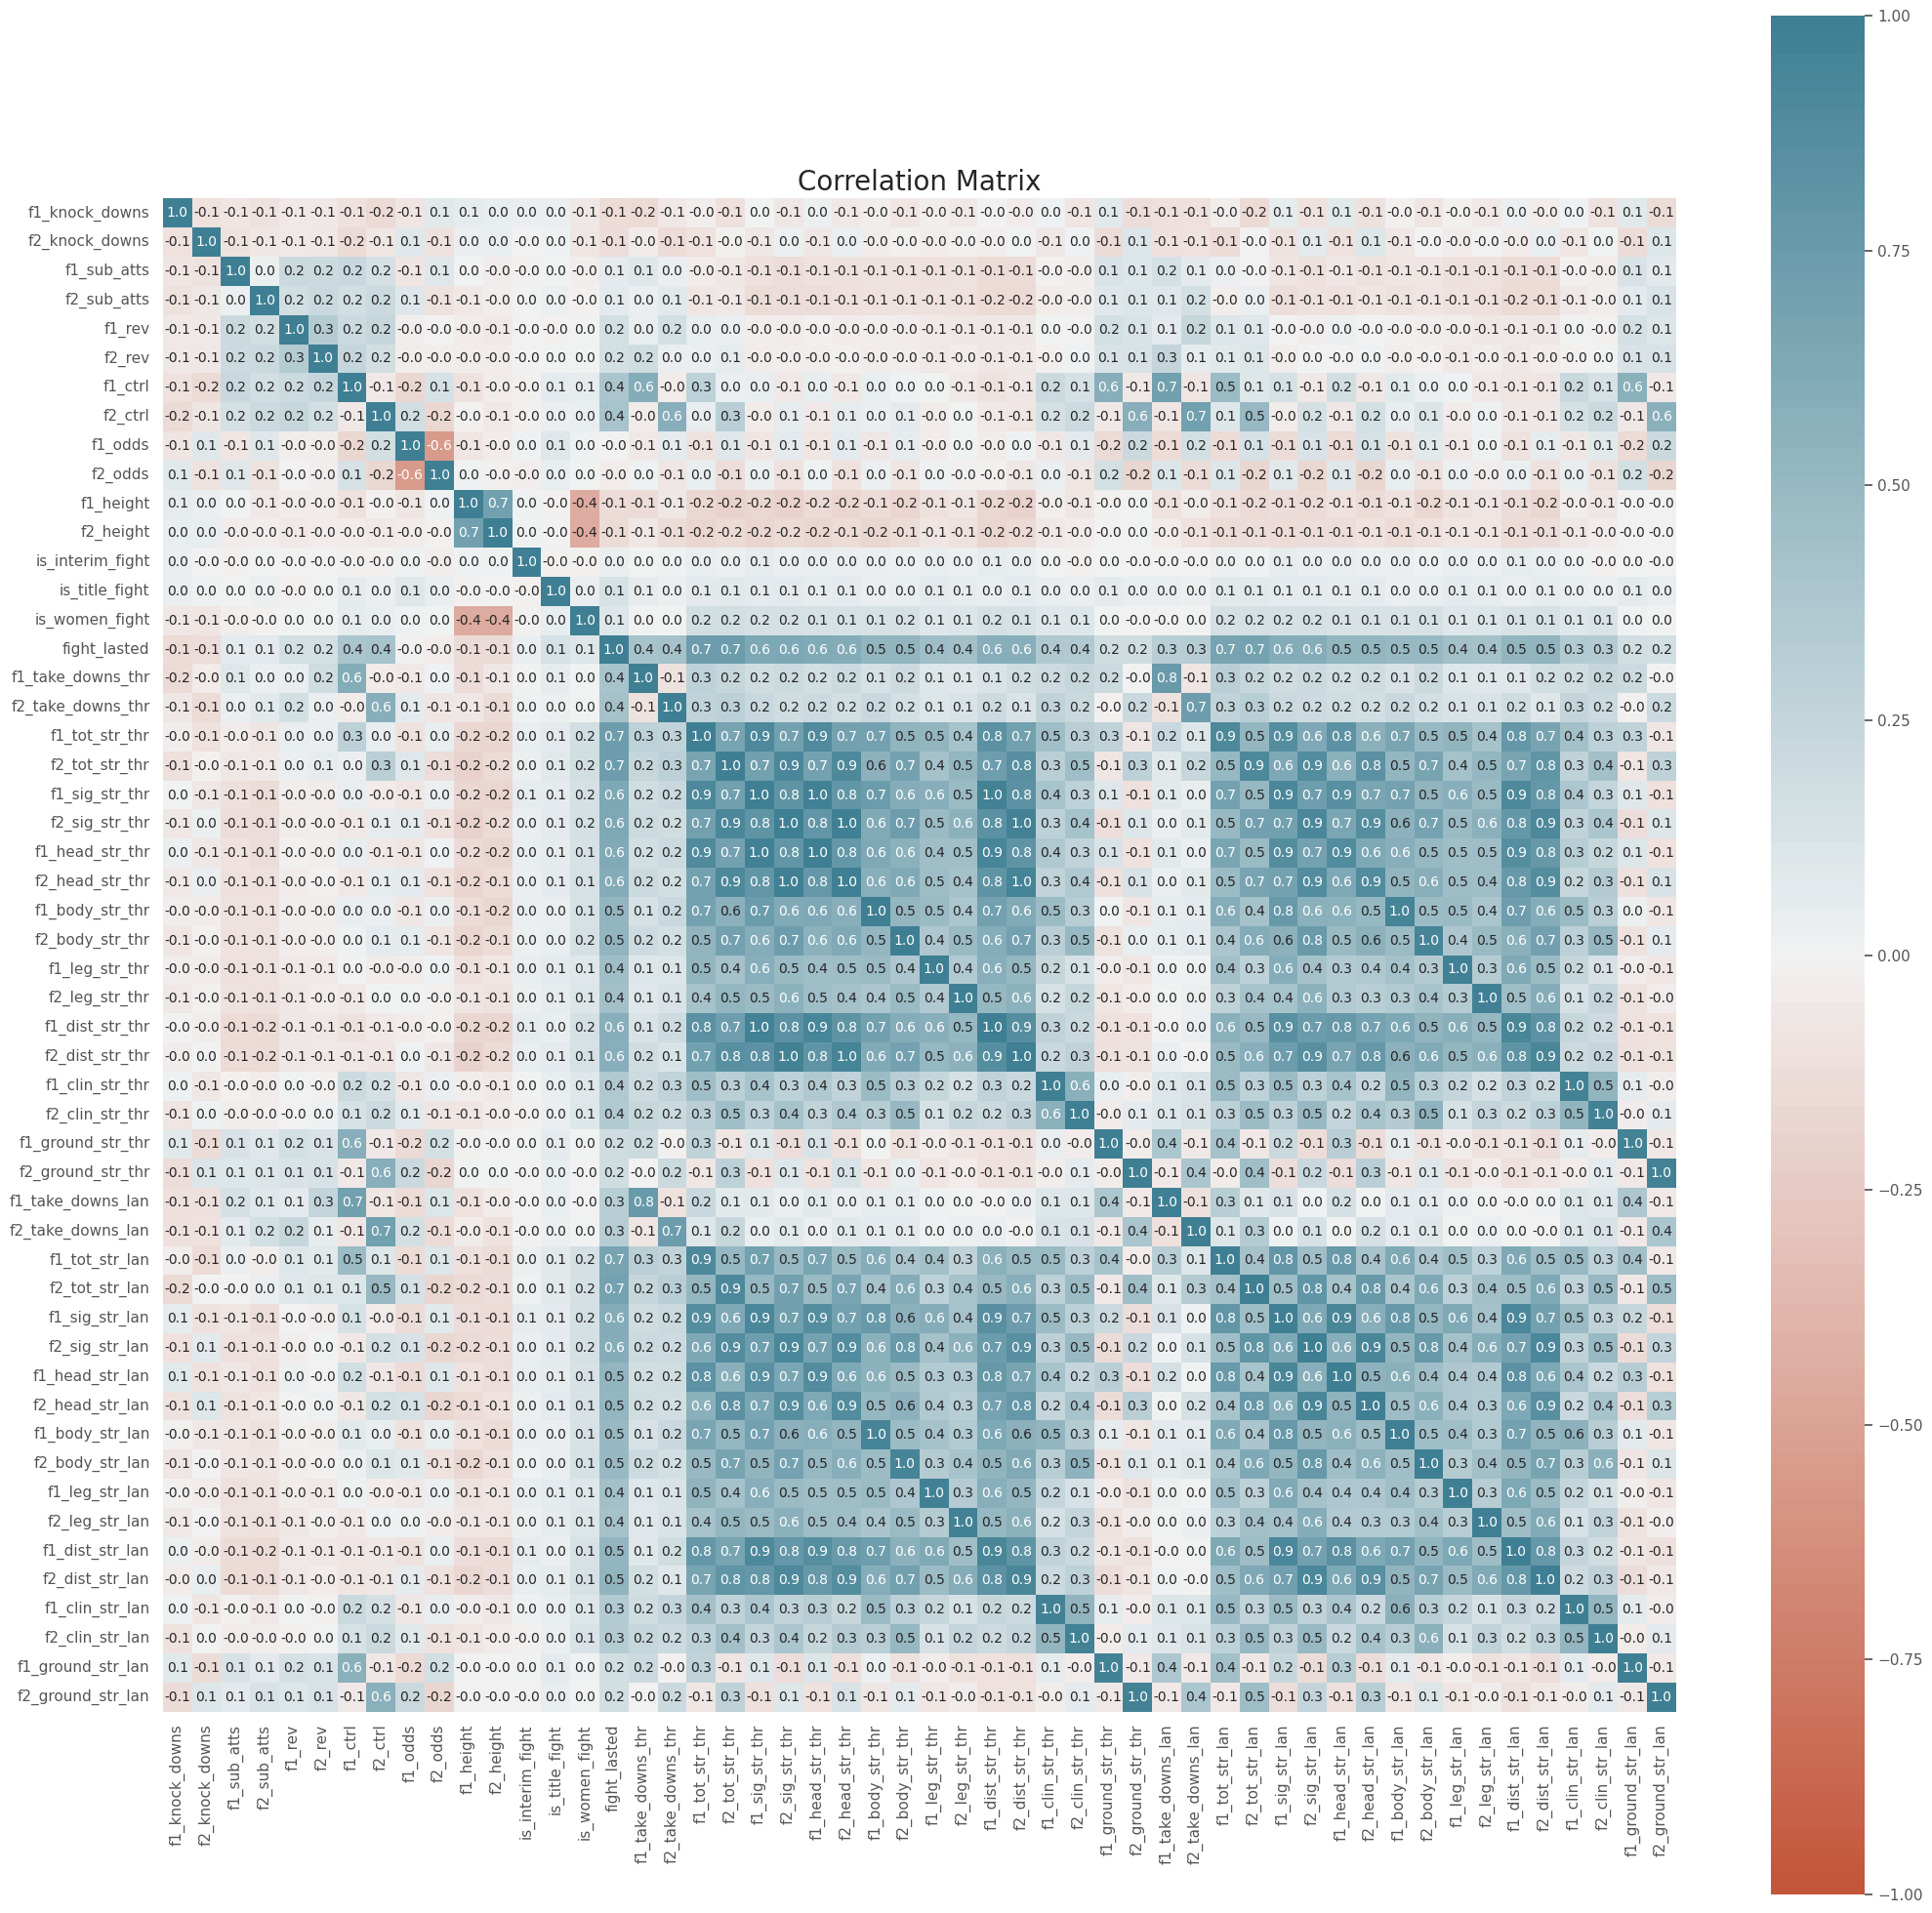

In [444]:
numerical_columns = df.select_dtypes(include=np.number).columns[1:].tolist()
plot_corr_matrix(df, numerical_columns)

### <div style="margin-left: 1em;">Correlated Features</div>
<div style="margin-left: 3em;"><font color='gray'>
   <strong><font color='#A9A9A9'>Positive</font></strong> 
      <li><u><font color='grey'>Height to Reach</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The taller a fighter is the wider hir arm reach will be</font></div>
      <li><u><font color='grey'>Fight lasted in seconds to strikes landed/thrown</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The longer a fight drags on the more strikes will be thrown</font></div>
      <li><u><font color='grey'>Total strikes to significant strikes</u></li>
         <div style="margin-left: 2em;"><font color='gray'>Significant strikes is just a portion of total ones</font></div>
      <li><u><font color='grey'>Strikes thrown and landed</u></li>
         <div style="margin-left: 2em;"><font color='gray'>Strikes landed make up a pat of thrown ones</font></div><br>
   <strong><font color='#A9A9A9'>Negative</font></strong> 
      <li><u><font color='grey'>Height/Reach to whether it's a women/men fight</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The taller a fighter is the lesser probability is that its a fight between women</font></div>
      <li><u><font color='grey'>Odds of the fighters</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The higher winning odds of a fighter the lesser ones of the other one</font></div>

These correlations wont matter for boosting models such as Catboost</font></div>

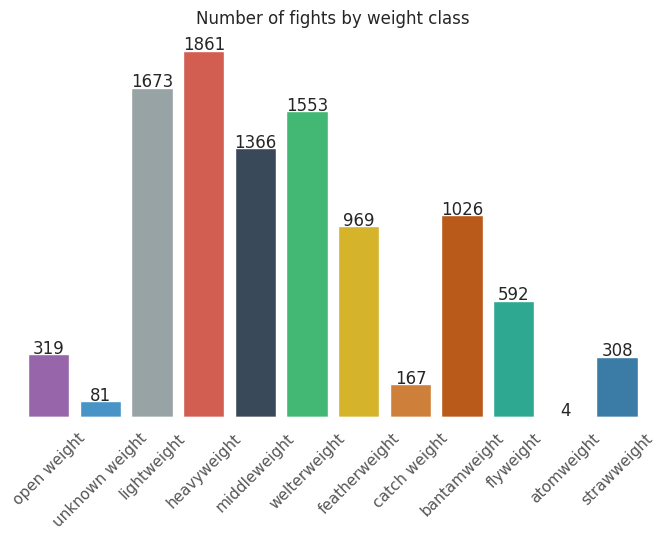

In [445]:
plot_countplot(
    events_df, 
    'weight_class', 
    "Number of fights by weight class"
)

<Figure size 800x500 with 0 Axes>

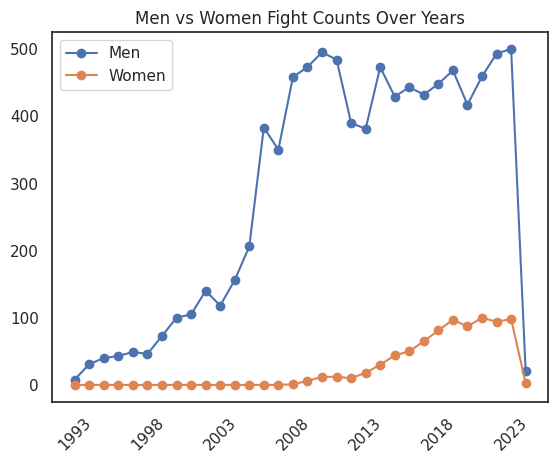

In [446]:
fight_counts = (
    df.groupby([df['event_date'].dt.year, 'is_women_fight'])
        .size()
        .unstack(fill_value=0)
)

plot_lineplot(
    df = fight_counts, 
    title = 'Men vs Women Fight Counts Over Years', 
    legend = ['Men', 'Women']
)

<div style="margin-left: 1em;"><font color='gray'>The women divition was introduced not that long ago hence the disproportion. The lines suddenly drop as we have data up to February 2024</font></div>

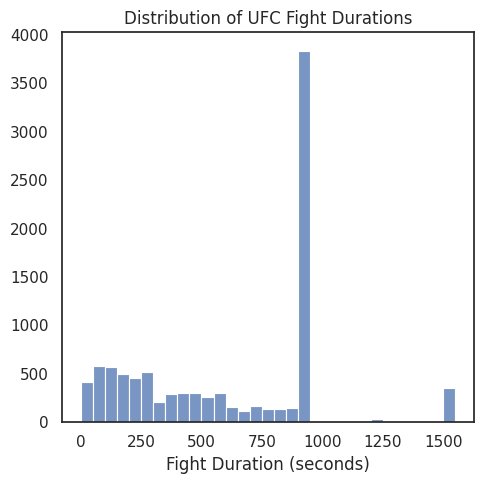

In [447]:
plot_hist(
    data=events_df, 
    x='fight_lasted', 
    bins=np.arange(0, 1600, 50), 
    xlabel = 'Fight Duration (seconds)',
    title = 'Distribution of UFC Fight Durations'
    )

<div style="margin-left: 1em;"><font color='gray'>As we can see most of the fights last all 5 rounds with some fights lasted around 1500 seconds. These are the old "Unlimited" fights. From the graph we can see that if probability of a fight to end in early rounds is higher and as the fights go on the probability decreases. It might have something to do with stamina depletion. </font></div>

In [448]:
event_country_counts = df['event_country'].value_counts()

fig = px.pie(
    names=event_country_counts.index,
    values=event_country_counts.values,
    title='UFC Events by Country',
    hole=0.5,
    width=700,
    height=500   
)

fig.update_traces(textposition='inside', textinfo='label')
fig.show()

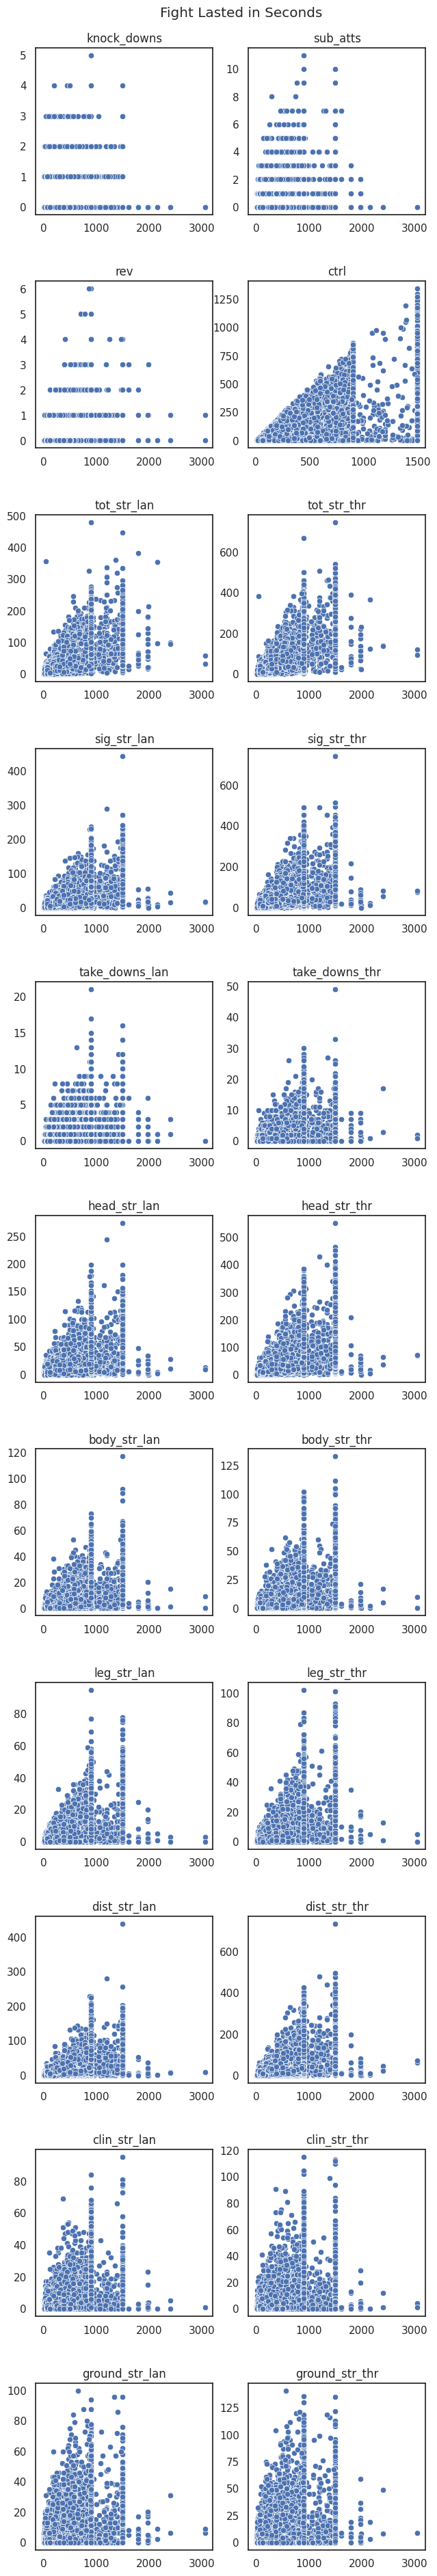

In [449]:
nrows=math.ceil(len(COLUMNS_FOR_SUBPLOTS)/2)

plot_scatterplots(
    df=fighters_df, 
    x = 'fight_lasted',
    columns=COLUMNS_FOR_SUBPLOTS, 
    title="Fight Lasted in Seconds", 
    nrows=nrows,
    ncols=2
    )

## 5. Feature Selection and Creation


In [450]:
# Creating age feature
fighters_df['age_at_event'] = (
    (fighters_df['event_date'] - fighters_df['dob']).dt.days / 365
)

# Creating wins, losses, draws, ncs and winning streaks
features_df = get_stats(fighters_df)
fighters_df = pd.concat([fighters_df, features_df], axis=1)

# Creating days_since_last_fight feature
fighters_df['days_since_last_fight'] = (
    fighters_df.groupby('name')['event_date'].diff().dt.days
)

fighters_df.tail()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,days_since_last_fight
19833,9916,2024-01-20,861.0,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68,1.0,3.0,0.0,685.0,326.0,398.0,93.0,120.0,2.0,5.0,84.0,109.0,6.0,8.0,3.0,3.0,23.0,34.0,2.0,3.0,68.0,83.0,W,34.912329,1,5,2,0,0,126.0
19834,9917,2024-01-20,900.0,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72,0.0,0.0,0.0,211.0,72.0,141.0,51.0,118.0,5.0,17.0,35.0,101.0,12.0,13.0,4.0,4.0,45.0,110.0,5.0,7.0,1.0,1.0,W,29.958904,8,8,0,0,0,259.0
19835,9917,2024-01-20,900.0,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70,0.0,1.0,0.0,3.0,61.0,143.0,59.0,140.0,0.0,0.0,41.0,115.0,17.0,24.0,1.0,1.0,46.0,124.0,9.0,12.0,4.0,4.0,L,30.013699,0,10,2,0,0,280.0
19836,9918,2024-01-20,900.0,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70,1.0,0.0,0.0,6.0,62.0,148.0,62.0,147.0,0.0,0.0,48.0,131.0,8.0,10.0,6.0,6.0,60.0,144.0,1.0,1.0,1.0,2.0,W,30.049315,2,2,1,0,0,102.0
19837,9918,2024-01-20,900.0,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72,0.0,0.0,0.0,24.0,81.0,229.0,79.0,226.0,0.0,4.0,51.0,181.0,20.0,36.0,8.0,9.0,73.0,218.0,6.0,8.0,0.0,0.0,L,27.564384,0,1,1,0,0,137.0


In [451]:
# Creating annual cumulative rolling features

year_in_weeks = 52

# Creating rolling mean features
rolling_mean_df = get_rolling_features(
    fighters_df, 
    COLUMNS_TO_GET_ROLLING_MEANS, 
    year_in_weeks, 
    'mean'
)
fighters_df = pd.concat([fighters_df, rolling_mean_df], axis=1)

# Creating rolling count features
rolling_count_cols = ['target']
rolling_count_df = get_rolling_features(
    fighters_df, 
    rolling_count_cols, 
    year_in_weeks, 
    'count'
)
fighters_df = pd.concat([fighters_df, rolling_count_df], axis=1)


fighters_df.rename(columns={
    'target_count_over_1_year':'num_of_fights_over_1_year'
    }, inplace=True)

fighters_df.drop(columns='target', inplace=True)
fighters_df.tail()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,days_since_last_fight,fight_lasted_mean_over_1_year,knock_downs_mean_over_1_year,sub_atts_mean_over_1_year,rev_mean_over_1_year,ctrl_mean_over_1_year,tot_str_lan_mean_over_1_year,tot_str_thr_mean_over_1_year,sig_str_lan_mean_over_1_year,sig_str_thr_mean_over_1_year,take_downs_lan_mean_over_1_year,take_downs_thr_mean_over_1_year,head_str_lan_mean_over_1_year,head_str_thr_mean_over_1_year,body_str_lan_mean_over_1_year,body_str_thr_mean_over_1_year,leg_str_lan_mean_over_1_year,leg_str_thr_mean_over_1_year,dist_str_lan_mean_over_1_year,dist_str_thr_mean_over_1_year,clin_str_lan_mean_over_1_year,clin_str_thr_mean_over_1_year,ground_str_lan_mean_over_1_year,ground_str_thr_mean_over_1_year,num_of_fights_over_1_year
19833,9916,2024-01-20,861.0,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68,1.0,3.0,0.0,685.0,326.0,398.0,93.0,120.0,2.0,5.0,84.0,109.0,6.0,8.0,3.0,3.0,23.0,34.0,2.0,3.0,68.0,83.0,34.912329,1,5,2,0,0,126.0,890.25,0.25,0.75,0.0,502.75,171.25,268.25,65.25,134.5,2.25,6.0,49.0,110.75,12.25,19.25,4.0,4.5,37.5,97.0,8.75,13.0,19.0,24.5,4
19834,9917,2024-01-20,900.0,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72,0.0,0.0,0.0,211.0,72.0,141.0,51.0,118.0,5.0,17.0,35.0,101.0,12.0,13.0,4.0,4.0,45.0,110.0,5.0,7.0,1.0,1.0,29.958904,8,8,0,0,0,259.0,900.0,0.0,0.0,0.0,360.5,127.5,184.5,69.5,123.5,4.5,12.0,55.5,108.5,7.5,8.0,6.5,7.0,45.0,95.5,8.0,9.0,16.5,19.0,2
19835,9917,2024-01-20,900.0,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70,0.0,1.0,0.0,3.0,61.0,143.0,59.0,140.0,0.0,0.0,41.0,115.0,17.0,24.0,1.0,1.0,46.0,124.0,9.0,12.0,4.0,4.0,30.013699,0,10,2,0,0,280.0,1200.0,0.0,0.5,0.0,22.5,70.5,186.0,67.5,182.5,0.0,0.0,44.5,144.0,17.5,30.0,5.5,8.5,61.0,174.5,4.5,6.0,2.0,2.0,2
19836,9918,2024-01-20,900.0,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70,1.0,0.0,0.0,6.0,62.0,148.0,62.0,147.0,0.0,0.0,48.0,131.0,8.0,10.0,6.0,6.0,60.0,144.0,1.0,1.0,1.0,2.0,30.049315,2,2,1,0,0,102.0,358.333333,0.666667,0.0,0.0,2.0,27.666667,61.333333,27.666667,61.0,0.0,0.0,21.666667,54.0,3.666667,4.666667,2.333333,2.333333,26.333333,59.333333,0.333333,0.333333,1.0,1.333333,3
19837,9918,2024-01-20,900.0,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72,0.0,0.0,0.0,24.0,81.0,229.0,79.0,226.0,0.0,4.0,51.0,181.0,20.0,36.0,8.0,9.0,73.0,218.0,6.0,8.0,0.0,0.0,27.564384,0,1,1,0,0,137.0,523.0,0.5,0.0,0.0,13.0,46.0,130.0,45.0,128.5,0.0,2.0,29.0,102.5,11.5,21.0,4.5,5.0,41.5,122.0,3.0,4.5,0.5,2.0,2


In [452]:
# Shifting values to prevent data leakage
for col in COLUMNS_TO_SHIFT:
    fighters_df[f"{col}_shift_1"] = (
        fighters_df.groupby(['name'])[f"{col}"].shift(1)
    )
    
fighters_df.drop(columns=COLUMNS_TO_SHIFT, inplace=True)
fighters_df.to_parquet('./processed_data/fighters_df.parquet')
fighters_df.tail()

,fight_id,event_date,name,dob,odds,height,stance,reach,age_at_event,days_since_last_fight,winning_streak_shift_1,wins_over_carrier_shift_1,losses_over_carrier_shift_1,draws_over_carrier_shift_1,ncs_over_carrier_shift_1,num_of_fights_over_1_year_shift_1,fight_lasted_shift_1,fight_lasted_mean_over_1_year_shift_1,knock_downs_shift_1,knock_downs_mean_over_1_year_shift_1,sig_str_lan_shift_1,sig_str_lan_mean_over_1_year_shift_1,sig_str_thr_shift_1,sig_str_thr_mean_over_1_year_shift_1,tot_str_lan_shift_1,tot_str_lan_mean_over_1_year_shift_1,tot_str_thr_shift_1,tot_str_thr_mean_over_1_year_shift_1,take_downs_lan_shift_1,take_downs_lan_mean_over_1_year_shift_1,take_downs_thr_shift_1,take_downs_thr_mean_over_1_year_shift_1,sub_atts_shift_1,sub_atts_mean_over_1_year_shift_1,rev_shift_1,rev_mean_over_1_year_shift_1,ctrl_shift_1,ctrl_mean_over_1_year_shift_1,head_str_lan_shift_1,head_str_lan_mean_over_1_year_shift_1,head_str_thr_shift_1,head_str_thr_mean_over_1_year_shift_1,body_str_lan_shift_1,body_str_lan_mean_over_1_year_shift_1,body_str_thr_shift_1,body_str_thr_mean_over_1_year_shift_1,leg_str_lan_shift_1,leg_str_lan_mean_over_1_year_shift_1,leg_str_thr_shift_1,leg_str_thr_mean_over_1_year_shift_1,dist_str_lan_shift_1,dist_str_lan_mean_over_1_year_shift_1,dist_str_thr_shift_1,dist_str_thr_mean_over_1_year_shift_1,clin_str_lan_shift_1,clin_str_lan_mean_over_1_year_shift_1,clin_str_thr_shift_1,clin_str_thr_mean_over_1_year_shift_1,ground_str_lan_shift_1,ground_str_lan_mean_over_1_year_shift_1,ground_str_thr_shift_1,ground_str_thr_mean_over_1_year_shift_1
19833,9916,2024-01-20,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68,34.912329,126.0,0.0,4.0,2.0,0.0,0.0,3,900.0,900.0,0.0,0.0,77.0,56.0,206.0,139.333333,95.0,119.666667,225.0,225.0,2.0,2.333333,10.0,6.333333,0.0,0.0,0.0,0.0,180.0,442.0,43.0,37.333333,148.0,111.333333,25.0,14.333333,47.0,23.0,9.0,4.333333,11.0,5.0,58.0,42.333333,176.0,118.0,19.0,11.0,30.0,16.333333,0.0,2.666667,0.0,5.0
19834,9917,2024-01-20,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72,29.958904,259.0,7.0,7.0,0.0,0.0,0.0,2,900.0,900.0,0.0,0.0,88.0,78.0,129.0,129.0,183.0,163.5,228.0,220.5,4.0,6.5,7.0,11.5,0.0,0.0,0.0,0.0,510.0,458.5,76.0,63.0,116.0,112.5,3.0,7.5,3.0,8.5,9.0,7.5,10.0,8.0,45.0,48.0,81.0,95.5,11.0,6.5,11.0,6.5,32.0,23.5,37.0,27.0
19835,9917,2024-01-20,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70,30.013699,280.0,0.0,10.0,1.0,0.0,0.0,2,1500.0,904.0,0.0,0.0,76.0,52.0,225.0,146.0,80.0,54.0,229.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,32.5,48.0,34.5,173.0,114.0,18.0,10.0,36.0,20.5,10.0,7.5,16.0,11.5,76.0,51.5,225.0,143.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2.5
19836,9918,2024-01-20,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70,30.049315,102.0,1.0,1.0,1.0,0.0,0.0,2,29.0,87.5,1.0,0.5,10.0,10.5,17.0,18.0,10.0,10.5,17.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.5,13.0,15.5,3.0,1.5,4.0,2.0,0.0,0.5,0.0,0.5,8.0,9.5,15.0,17.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0
19837,9918,2024-01-20,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72,27.564384,137.0,1.0,1.0,0.0,0.0,0.0,1,146.0,146.0,1.0,1.0,11.0,11.0,31.0,31.0,11.0,11.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,7.0,24.0,24.0,3.0,3.0,6.0,6.0,1.0,1.0,1.0,1.0,10.0,10.0,26.0,26.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0


In [453]:
# Remerging dataframes for model training
baseline_df = events_df

fighters = [1,2]

for num in fighters:
    
    baseline_df = pd.merge(
        baseline_df, 
        fighters_df.rename(add_fighter_prefix(num, fighters_df), axis=1),
        how='left',
        on=['fight_id', 'event_date', f'f{num}_name']
    )
baseline_df.to_parquet('./processed_data/baseline_df.parquet')
baseline_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,target,f1_dob,f1_odds,f1_height,f1_stance,f1_reach,f1_age_at_event,f1_days_since_last_fight,f1_winning_streak_shift_1,f1_wins_over_carrier_shift_1,f1_losses_over_carrier_shift_1,f1_draws_over_carrier_shift_1,f1_ncs_over_carrier_shift_1,f1_num_of_fights_over_1_year_shift_1,f1_fight_lasted_shift_1,f1_fight_lasted_mean_over_1_year_shift_1,f1_knock_downs_shift_1,f1_knock_downs_mean_over_1_year_shift_1,f1_sig_str_lan_shift_1,f1_sig_str_lan_mean_over_1_year_shift_1,f1_sig_str_thr_shift_1,f1_sig_str_thr_mean_over_1_year_shift_1,f1_tot_str_lan_shift_1,f1_tot_str_lan_mean_over_1_year_shift_1,f1_tot_str_thr_shift_1,f1_tot_str_thr_mean_over_1_year_shift_1,f1_take_downs_lan_shift_1,f1_take_downs_lan_mean_over_1_year_shift_1,f1_take_downs_thr_shift_1,f1_take_downs_thr_mean_over_1_year_shift_1,f1_sub_atts_shift_1,f1_sub_atts_mean_over_1_year_shift_1,f1_rev_shift_1,f1_rev_mean_over_1_year_shift_1,f1_ctrl_shift_1,f1_ctrl_mean_over_1_year_shift_1,f1_head_str_lan_shift_1,f1_head_str_lan_mean_over_1_year_shift_1,f1_head_str_thr_shift_1,f1_head_str_thr_mean_over_1_year_shift_1,f1_body_str_lan_shift_1,f1_body_str_lan_mean_over_1_year_shift_1,f1_body_str_thr_shift_1,f1_body_str_thr_mean_over_1_year_shift_1,f1_leg_str_lan_shift_1,f1_leg_str_lan_mean_over_1_year_shift_1,f1_leg_str_thr_shift_1,f1_leg_str_thr_mean_over_1_year_shift_1,f1_dist_str_lan_shift_1,f1_dist_str_lan_mean_over_1_year_shift_1,f1_dist_str_thr_shift_1,f1_dist_str_thr_mean_over_1_year_shift_1,f1_clin_str_lan_shift_1,f1_clin_str_lan_mean_over_1_year_shift_1,f1_clin_str_thr_shift_1,f1_clin_str_thr_mean_over_1_year_shift_1,f1_ground_str_lan_shift_1,f1_ground_str_lan_mean_over_1_year_shift_1,f1_ground_str_thr_shift_1,f1_ground_str_thr_mean_over_1_year_shift_1,f2_dob,f2_odds,f2_height,f2_stance,f2_reach,f2_age_at_event,f2_days_since_last_fight,f2_winning_streak_shift_1,f2_wins_over_carrier_shift_1,f2_losses_over_carrier_shift_1,f2_draws_over_carrier_shift_1,f2_ncs_over_carrier_shift_1,f2_num_of_fights_over_1_year_shift_1,f2_fight_lasted_shift_1,f2_fight_lasted_mean_over_1_year_shift_1,f2_knock_downs_shift_1,f2_knock_downs_mean_over_1_year_shift_1,f2_sig_str_lan_shift_1,f2_sig_str_lan_mean_over_1_year_shift_1,f2_sig_str_thr_shift_1,f2_sig_str_thr_mean_over_1_year_shift_1,f2_tot_str_lan_shift_1,f2_tot_str_lan_mean_over_1_year_shift_1,f2_tot_str_thr_shift_1,f2_tot_str_thr_mean_over_1_year_shift_1,f2_take_downs_lan_shift_1,f2_take_downs_lan_mean_over_1_year_shift_1,f2_take_downs_thr_shift_1,f2_take_downs_thr_mean_over_1_year_shift_1,f2_sub_atts_shift_1,f2_sub_atts_mean_over_1_year_shift_1,f2_rev_shift_1,f2_rev_mean_over_1_year_shift_1,f2_ctrl_shift_1,f2_ctrl_mean_over_1_year_shift_1,f2_head_str_lan_shift_1,f2_head_str_lan_mean_over_1_year_shift_1,f2_head_str_thr_shift_1,f2_head_str_thr_mean_over_1_year_shift_1,f2_body_str_lan_shift_1,f2_body_str_lan_mean_over_1_year_shift_1,f2_body_str_thr_shift_1,f2_body_str_thr_mean_over_1_year_shift_1,f2_leg_str_lan_shift_1,f2_leg_str_lan_mean_over_1_year_shift_1,f2_leg_str_thr_shift_1,f2_leg_str_thr_mean_over_1_year_shift_1,f2_dist_str_lan_shift_1,f2_dist_str_lan_mean_over_1_year_shift_1,f2_dist_str_thr_shift_1,f2_dist_str_thr_mean_over_1_year_shift_1,f2_clin_str_lan_shift_1,f2_clin_str_lan_mean_over_1_year_shift_1,f2_clin_str_thr_shift_1,f2_clin_str_thr_mean_over_1_year_shift_1,f2_ground_str_lan_shift_1,f2_ground_str_lan_mean_over_1_year_shift_1,f2_ground_str_thr_shift_1,f2_ground_str_thr_mean_over_1_year_shift_1
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,F1,1959-03-30,NaN,77.0,Orthodox,None,34.646575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,76.0,Orthodox,Non

## 6. Model Training

In [454]:
baseline_df = pd.read_parquet('./processed_data/baseline_df.parquet')

In [455]:
split_date = baseline_df['event_date'].max() - pd.Timedelta(days=352)
split_date

Timestamp('2023-02-02 00:00:00')

In [456]:
np.random.seed(42)

pd.DataFrame.iteritems = pd.DataFrame.items


df_train = baseline_df[baseline_df['event_date'] <= split_date]
df_test = baseline_df[baseline_df['event_date'] > split_date]

drop_features = (
    ['fight_id', 'fight_lasted','event_date', 'method',
    'referee', 'details', 'f1_name', 'f2_name', 'target', 'f1_dob', 'f2_dob'] 
)

features = list(
    set(baseline_df.columns) - 
    set(drop_features) 
) 

cat_features = ['event_country', 'weight_class', 'f1_stance', 'f2_stance']

tscv = TimeSeriesSplit(n_splits=5)  

precision_scores = []

for train_index, val_index in tscv.split(df_train):
    X_split_train = df_train.loc[train_index,features]
    X_split_val = df_train.loc[val_index, features]
    y_split_train = df_train.loc[train_index, 'target']
    y_split_val = df_train.loc[val_index, 'target']

    CBC = CatBoostClassifier(
        n_estimators=2000,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100,
    )
    CBC.fit(
        X_split_train, 
        y_split_train, 
        eval_set=(X_split_val, y_split_val),
        cat_features=cat_features
    )
    y_pred = CBC.predict(X_split_val)
    precision = precision_score(
        y_split_val, 
        y_pred, 
        average='micro', 
        zero_division='warn'
    )
    precision_scores.append(precision)

Learning rate set to 0.083592
0:	learn: 1.2942411	test: 1.3039239	best: 1.3039239 (0)	total: 15.9ms	remaining: 31.9s
100:	learn: 0.4886335	test: 0.6443807	best: 0.6443807 (100)	total: 2.13s	remaining: 40.1s
200:	learn: 0.3674628	test: 0.6409806	best: 0.6402171 (197)	total: 4.22s	remaining: 37.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6390210998
bestIteration = 212

Shrink model to first 213 iterations.
Learning rate set to 0.084759
0:	learn: 1.2889397	test: 1.3071897	best: 1.3071897 (0)	total: 19.1ms	remaining: 38.2s


100:	learn: 0.5339574	test: 0.7351047	best: 0.7341939 (82)	total: 2.5s	remaining: 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7341938773
bestIteration = 82

Shrink model to first 83 iterations.
Learning rate set to 0.085449
0:	learn: 1.2879099	test: 1.2994126	best: 1.2994126 (0)	total: 21.1ms	remaining: 42.2s
100:	learn: 0.5888987	test: 0.7270688	best: 0.7270688 (100)	total: 2.69s	remaining: 50.6s
200:	learn: 0.5038891	test: 0.7180182	best: 0.7172411 (173)	total: 5.44s	remaining: 48.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7172410751
bestIteration = 173

Shrink model to first 174 iterations.
Learning rate set to 0.085942
0:	learn: 1.2964636	test: 1.3088706	best: 1.3088706 (0)	total: 21.7ms	remaining: 43.4s
100:	learn: 0.6067445	test: 0.7232334	best: 0.7224068 (78)	total: 2.46s	remaining: 46.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.721568646
bestIteration = 122

Shrink model to first 123 iterations.


In [457]:
np.mean(precision_scores)

0.6253539253539253

In [458]:
CBC = CatBoostClassifier(
        n_estimators=2000,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100
    )
CBC.fit(
    df_train[features], 
    df_train['target'], 
    eval_set=(    
        df_test[features], 
        df_test['target']),
    verbose=100,
    cat_features=cat_features
)
y_pred = CBC.predict(df_test[features])
precision = precision_score(df_test['target'], y_pred, average='micro')
precision

Learning rate set to 0.086642
0:	learn: 1.2945484	test: 1.3092135	best: 1.3092135 (0)	total: 24.4ms	remaining: 48.7s
100:	learn: 0.6414100	test: 0.7879491	best: 0.7842814 (55)	total: 2.78s	remaining: 52.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7842814337
bestIteration = 55

Shrink model to first 56 iterations.


0.6

In [459]:
print(classification_report(df_test['target'], y_pred))

              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00         7
          F1       0.60      0.61      0.60       289
          F2       0.60      0.63      0.61       289
          NC       0.00      0.00      0.00        10

    accuracy                           0.60       595
   macro avg       0.30      0.31      0.30       595
weighted avg       0.58      0.60      0.59       595



/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [460]:
pd.DataFrame(
    np.vstack([CBC.feature_names_, CBC.feature_importances_]).T, 
    columns = ['features', 'score']
    )\
        .astype({'score': float})\
        .sort_values('score', ascending=False)\
        .head(20)

,features,score
109,f2_reach,20.164034
63,f1_reach,20.090091
77,f2_odds,8.042352
117,f1_odds,6.482453
56,f1_age_at_event,3.036490
55,f2_age_at_event,2.375871
91,f1_wins_over_carrier_shift_1,1.769061
0,f1_ground_str_lan_mean_over_1_year_shift_1,1.513625
54,f1_winning_streak_shift_1,1.459227
119,f2_days_since_last_fight,1.392356


In [461]:
def objective(trial):

    params = {
        "learning_rate": 
            trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "objective": 
            trial.suggest_categorical(
                "objective", ["MultiClass", "MultiClassOneVsAll"]
                ),
        "colsample_bylevel": 
            trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": 
            trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": 
            trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "random_strength": 
            trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "boosting_type": 
            trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": 
            trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = (
            trial.suggest_float("bagging_temperature", 0, 10)
        )
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = (
            trial.suggest_float("subsample", 0.1, 1, log=True)
        )
        
    tscv = TimeSeriesSplit(n_splits=5)  

    precision_scores = []

    for train_index, val_index in tscv.split(df_train):
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        CBC = CatBoostClassifier(
            **params,
            n_estimators=2000,
            loss_function='MultiClass',
            od_type = "Iter",
            od_wait = 50,
            verbose=False
        )
        CBC.fit(
            train_data[features], 
            train_data['target'], 
            cat_features=cat_features
        )
        y_pred = CBC.predict(val_data[features])
        precision = precision_score(
            val_data['target'], 
            y_pred, 
            average='micro'
            )
        precision_scores.append(precision)

    return np.mean(precision_scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)

study = optuna.create_study(direction="maximize", sampler=sampler)

In [462]:
study.optimize(objective, n_trials=100)

[W 2024-03-01 00:14:12,519] Trial 6 failed with parameters: {'learning_rate': 0.07161717085944734, 'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.053210579087444206, 'depth': 11, 'l2_leaf_reg': 0.017247337846684453, 'random_strength': 0.05734319754912758, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_6356/1682224259.py", line 51, in objective
    CBC.fit(
  File "/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/catboost/core.py"

KeyboardInterrupt: 

In [ ]:
study_df = study.trials_dataframe()
study_df.to_parquet("./CBC_study.parquet")
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

In [ ]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 0.021500331023939428, 'objective': 'MultiClass', 'colsample_bylevel': 0.0949480886778806, 'depth': 7, 'l2_leaf_reg': 10.59298622792364, 'random_strength': 0.38754349873601873, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(
    study, 
    params=[
        "learning_rate",
        "objective",
        "colsample_bylevel",
        "depth",
        "random_strength",
        "l2_leaf_reg",
        "boosting_type",
        "bootstrap_type",
        "bagging_temperature",
        "subsample"
    ]
)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

tscv = TimeSeriesSplit(n_splits=5)  

precision_scores = []

for train_index, val_index in tscv.split(df_train):
    X_split_train = df_train.loc[train_index,features]
    X_split_val = df_train.loc[val_index, features]
    y_split_train = df_train.loc[train_index, 'target']
    y_split_val = df_train.loc[val_index, 'target']

    CBC = CatBoostClassifier(
        **best_params,
        n_estimators=2000,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100
    )
    CBC.fit(
        X_split_train, 
        y_split_train, 
        eval_set=(X_split_val, y_split_val),
        cat_features=cat_features
    )
    y_pred = CBC.predict(X_split_val)
    precision = precision_score(y_split_val, y_pred, average='micro')
    precision_scores.append(precision)

0:	learn: 1.3704675	test: 1.3716970	best: 1.3716970 (0)	total: 5.37ms	remaining: 10.7s
100:	learn: 0.7396328	test: 0.8229818	best: 0.8229818 (100)	total: 656ms	remaining: 12.3s
200:	learn: 0.6038746	test: 0.7166537	best: 0.7166537 (200)	total: 1.36s	remaining: 12.2s
300:	learn: 0.5456187	test: 0.6799348	best: 0.6799348 (300)	total: 2.06s	remaining: 11.6s


400:	learn: 0.5082285	test: 0.6627232	best: 0.6627232 (400)	total: 2.78s	remaining: 11.1s
500:	learn: 0.4813802	test: 0.6546271	best: 0.6546271 (500)	total: 3.45s	remaining: 10.3s
600:	learn: 0.4581227	test: 0.6513856	best: 0.6513856 (600)	total: 4.15s	remaining: 9.65s
700:	learn: 0.4412194	test: 0.6488951	best: 0.6488951 (700)	total: 4.83s	remaining: 8.95s
800:	learn: 0.4257297	test: 0.6476345	best: 0.6476345 (800)	total: 5.53s	remaining: 8.28s
900:	learn: 0.4111759	test: 0.6466764	best: 0.6466764 (900)	total: 6.21s	remaining: 7.58s
1000:	learn: 0.3975348	test: 0.6459608	best: 0.6459608 (1000)	total: 6.93s	remaining: 6.92s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6459287679
bestIteration = 1001

Shrink model to first 1002 iterations.
0:	learn: 1.3676894	test: 1.3687388	best: 1.3687388 (0)	total: 5.78ms	remaining: 11.5s
100:	learn: 0.7191239	test: 0.8270560	best: 0.8270560 (100)	total: 772ms	remaining: 14.5s
200:	learn: 0.6109838	test: 0.7606981	best: 0.76069

In [ ]:
np.mean(precision_scores)

0.6281499692685925

In [ ]:
importances = permutation_importance(
    CBC, 
    df_train[features], 
    df_train['target'], 
    scoring='precision_micro', 
    n_repeats=10
)

feature_importances = pd.DataFrame(columns=['features', 'importance'])

for i, feat in enumerate(features):
    feature_importances.at[i, 'features'] = feat
    feature_importances.at[i, 'importance'] = importances['importances_mean'][i]

feature_importances.sort_values(by='importance', ascending=False).tail()

# Precision (average='micro')
# Baseline - 0.5172413793103449
# Initial oputna search - 0.7548387096774194
# Secondary oputna search - 0.7612903225806451
# 3rd oputna search - 0.6129032258064516
# 4th oputna search - 0.7612903225806451

,features,importance
15,f2_knock_downs_shift_1,-0.000261
23,f1_dist_str_lan_mean_over_1_year_shift_1,-0.000407
72,f1_sub_atts_shift_1,-0.000428
120,f2_ground_str_thr_shift_1,-0.000636
33,f1_sig_str_thr_mean_over_1_year_shift_1,-0.000918


/home/radionnazmiev/anaconda3/envs/py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

invalid value encountered in reduce



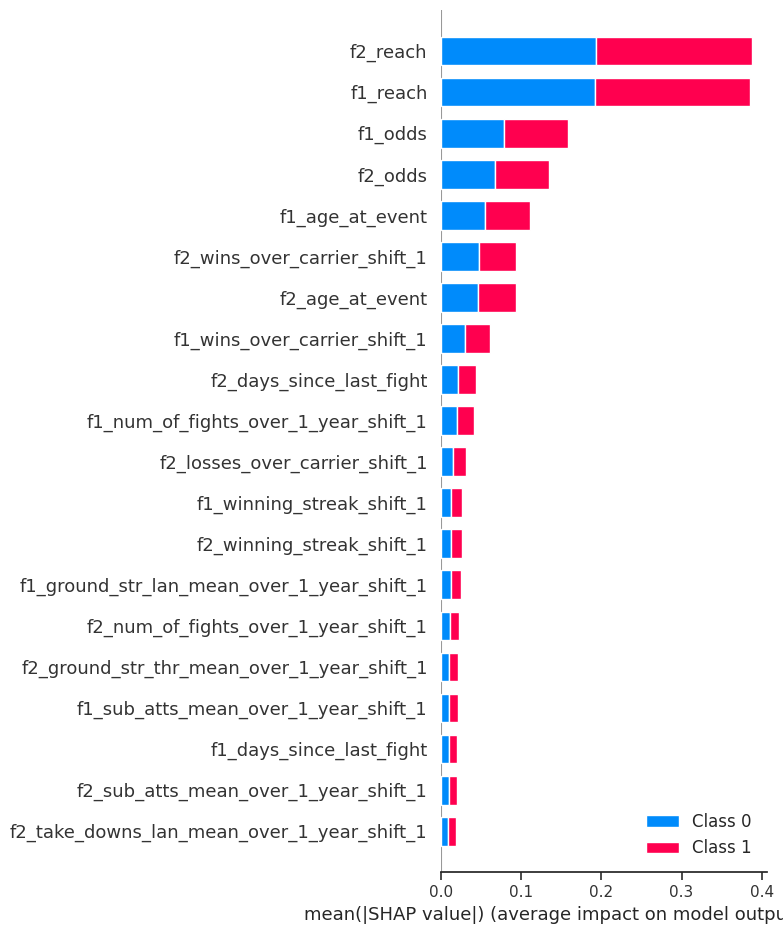

In [ ]:
shap_values = shap.Explainer(CBC).shap_values(df_train[features])
shap.summary_plot(
    shap_values, 
    df_train[features],
    plot_type="bar",  
    max_display=20
)

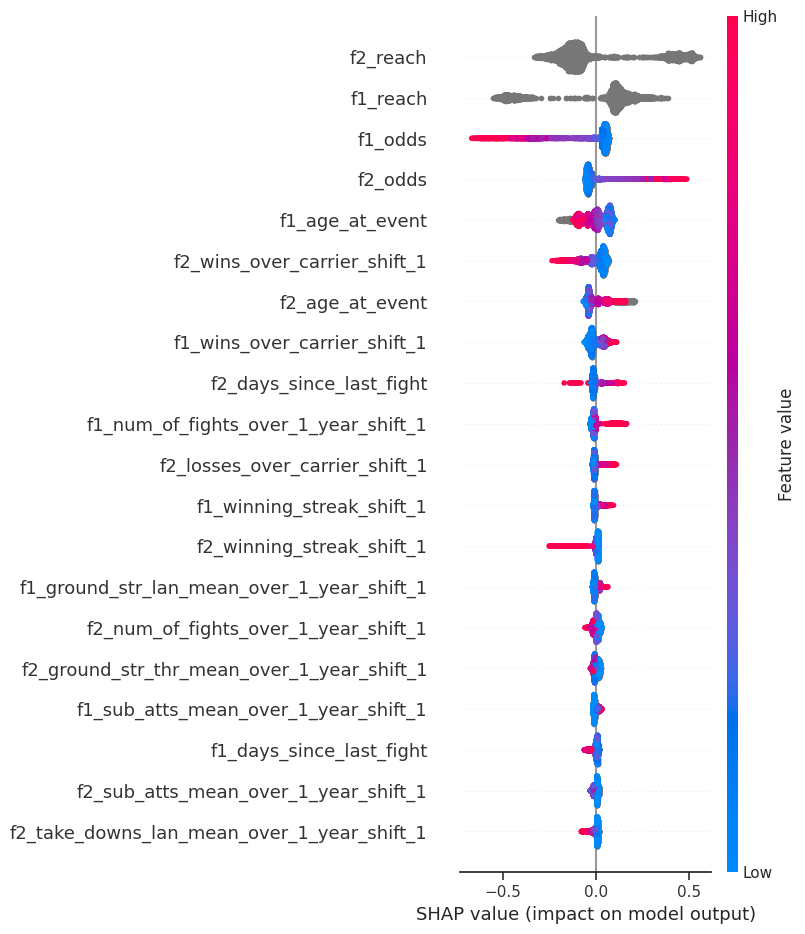

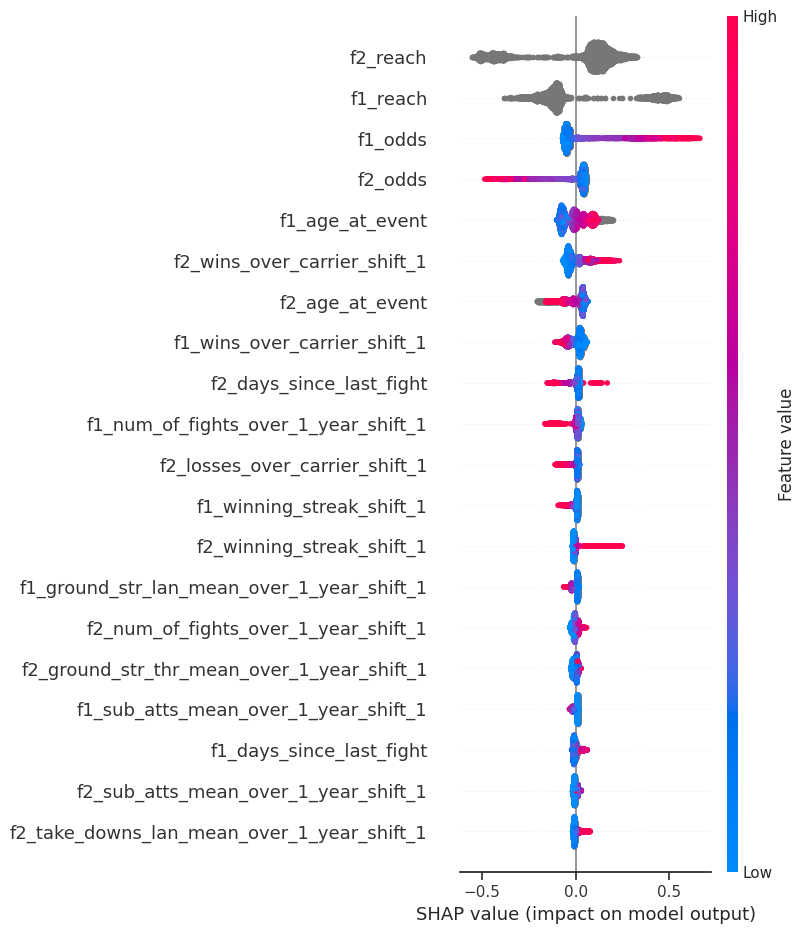

IndexError: list index out of range

In [ ]:
for i in range(4): 
    shap.summary_plot(
        shap_values[i],
        df_train[features],
        plot_type="dot"
    )